# Food and Agricultural Trends

**Team Papillon**

Nowadays, environmental problems are becoming more and more serious and urgent to deal with. We cannot deny the impact of food and agriculture in general, on the environment. If we consider what we eat and how we grow it, we would find extensive damage to the environment (green gas emissions, soil depletion etc.) and also the wildlife (due to pesticides, fertilizers etc.). We are looking to use the data provided by FAOSTAT giving access to over 3 million time-series and cross sectional data relating to food and agriculture all over the world and try to generate insights and stories on the evolution of different socio-environmental factors such as the correlation between greenhouse gas emissions and agricultural growth for example. Through this work, we hope to gain a deeper insight on the evolution and the environmental impact of agriculture and food.

## Question 1 and 2

### Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
### Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import StandardScaler

## Importing the data

In order to find a model that helps in the understanding of the role of the variety of crops in the ecological influence of the agriculture, we need 3 datasets:

- The land usage
- The crops cultures
- The emissions related to the agriculture


In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")

dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")

dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")

## Cleaning

- Removing NAN
- Removing useless columns

In [3]:
dataLands = dataLands.dropna(subset=["element"])

dataCrops = dataCrops.dropna(subset=["element"])

dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})

Here is a graph that shows the progression of land usage within each continent.

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


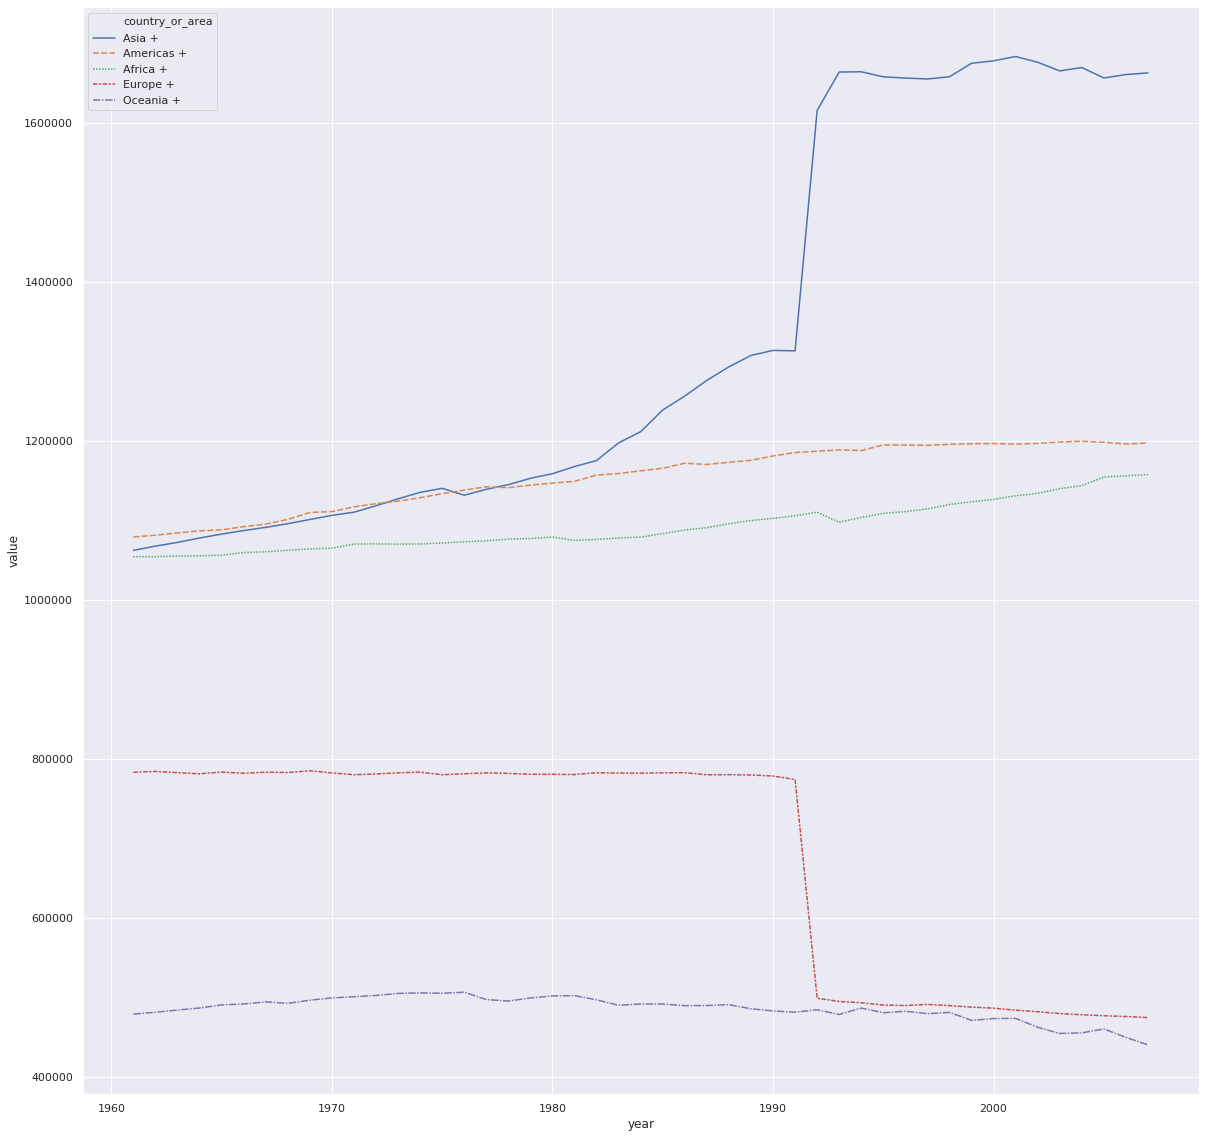

In [4]:
def cond_countries(dataLands):
    countries = ["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]
    truthTable = (dataLands["country_or_area"] == countries[0])
    for c in countries:
        truthTable = (dataLands["country_or_area"] == c) | truthTable
    return truthTable

dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
                                .where(cond_countries(dataLands))\
                                .dropna(subset=["country_or_area"])\
                                .sort_values("value",ascending=False)

sns.set(style="darkgrid")

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=dataLandsContinent, hue="country_or_area", ax=axes)

fg.show()

Here are the emissions of the BRICS throughout the years. We can see a clear progression (except for South Africa).

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


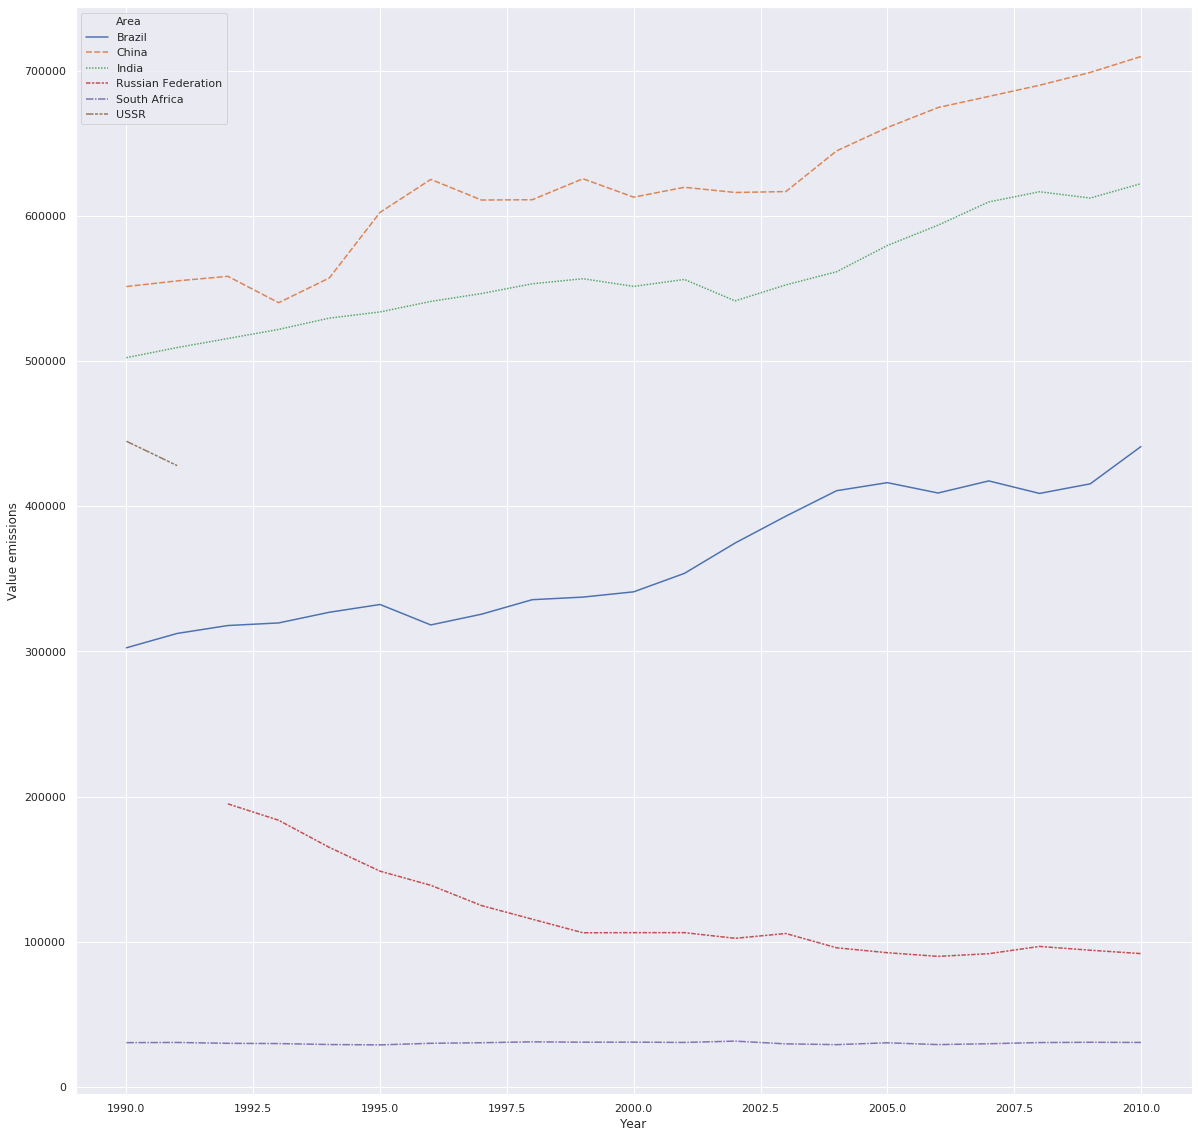

In [5]:
sns.set(style="darkgrid")

dataEmissionsAgrContinent = dataEmissionsAgriculture.where(dataEmissionsAgriculture["Area"].isin(["South Africa","Brazil", "China", "India", "USSR","Russian Federation"])).dropna()

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Value emissions", style="Area", data=dataEmissionsAgrContinent, hue="Area", ax=axes)

fg.show()

## Creating the dataset for processing

The dataset we create for processing consist in the aggregation of the area harvested of for each crop, by year and by country, and the emissions of greenhouse gases by year and by country as well. The goal will be to find a model that explain and helps in predicting the emissions, based on the other features (country, year and crops).

In [6]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions = crops.pivot_table(values='Value area',index=["Area","Year"],columns="category").reset_index()
cropsAndEmissions = cropsAndEmissions.fillna(0)
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])
cropsAndEmissions

,Area,Year,agave_fibres_nes,almonds_with_shell,anise_badian_fennel_corian,apples,apricots,arecanuts,artichokes,asparagus,...,vegetables_melons_total,vetches,walnuts_with_shell,watermelons,wheat,yams,yautia_cocoyam,Area Code,Unit emissions,Value emissions
29,Afghanistan,1990.0,0.0,5400.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,54600.0,0.0,2300.0,8200.0,1570000.0,0.0,0.0,2.0,Gigagrams,7342.7099
30,Afghanistan,1991.0,0.0,5500.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,52500.0,0.0,2300.0,7800.0,1690000.0,0.0,0.0,2.0,Gigagrams,7631.0272
31,Afghanistan,1992.0,0.0,5500.0,700.0,2340.0,5060.0,0.0,0.0,0.0,...,52900.0,0.0,2300.0,7800.0,1600000.0,0.0,0.0,2.0,Gigagrams,7631.4427
32,Afghanistan,1993.0,0.0,5500.0,700.0,2300.0,5100.0,0.0,0.0,0.0,...,54900.0,0.0,2300.0,7800.0,1900000.0,0.0,0.0,2.0,Gigagrams,7702.7416
33,Afghanistan,1994.0,0.0,5500.0,700.0,2350.0,5100.0,0.0,0.0,0.0,...,56900.0,0.0,2300.0,7800.0,2000000.0,0.0,0.0,2.0,Gigagrams,7699.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,Zimbabwe,2003.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,25937.0,0.0,0.0,0.0,26500.0,0.0,0.0,181.0,Gigagrams,9779.6837
10728,Zimbabwe,2004.0,0.0,0.0,200.0,750.0,20.0,0.0,17.0,60.0,...,26092.0,0.0,0.0,0.0,26300.0,0.0,0.0,181.0,Gigagrams,10470.7635
10729,Zimbabwe,2005.0,0.0,0.0,200.0,900.0,20.0,0.0,17.0,60.0,...,26242.0,0.0,0.0,0.0,28000.0,0.0,0.0,181.0,Gigagrams,9877.5998
10730,Zimbabwe,2006.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,23502.0,0.0,0.0,0.0,35000.0,0.0,0.0,181.0,Gigagrams,10053.3116


## Learning to predict emissions

Here, we try to create a model by doing a logistic regression on the data. We first try to optimize the alpha parameter on a predefined interval and then we use it to train the model.

Best alpha is 29.032258064516128 with a MSE of 392737681.660032 .


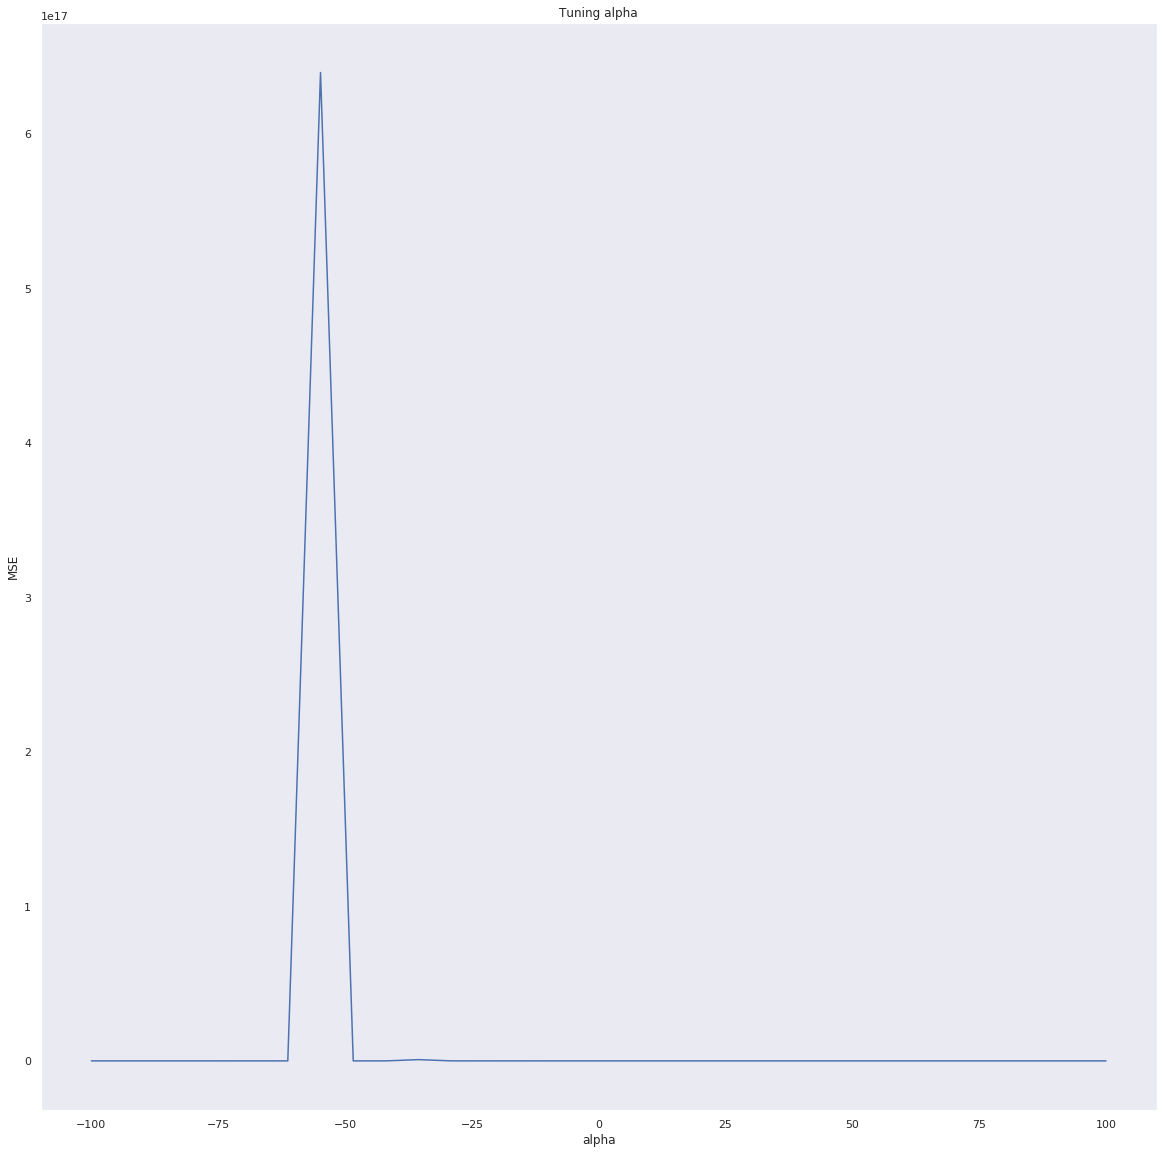

In [7]:
SEED = 1
st_pipeline = Pipeline([('scl', StandardScaler()), ('ridge', Ridge(copy_X=True, random_state=SEED))])
st_pipeline

#features = ["Area","category"]

XRidge2 = pd.get_dummies(cropsAndEmissions.drop(["Area Code","Unit emissions", "Value emissions"], axis=1))
yRidge2 = cropsAndEmissions["Value emissions"]

results = []

# Tune for alpha using 10 fold crossvalidation when calculating the mean squared error.
for alpha in np.linspace(-100, 100, 32):
    st_pipeline.set_params(ridge__alpha= alpha) 
    neg_MSE = cross_val_score(st_pipeline, XRidge2, yRidge2, scoring='neg_mean_squared_error', cv=10)  # we use 10 folds crossvalidation since 10 
                                                                                                      # is pretty much standard in the industry
    results.append([neg_MSE, alpha])
    
# Take the mean MSE for each level of alpha
for i in range(len(results)):
    results[i][0] = -np.mean(results[i][0])
    
# Plot the results
plt.figure(figsize=(20,20))
plt.plot([row[1] for row in results], [row[0] for row in results])
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Tuning alpha');
plt.grid()

best_st_alpha = min(results)[1]
print('Best alpha is', best_st_alpha, 'with a MSE of', min(results)[0],'.')

In [8]:
st_Model = st_pipeline.set_params(ridge__alpha= best_st_alpha)  # use best alpha calculated above
st_Model.fit(XRidge2, yRidge2)                                  # fit the new model

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=29.032258064516128, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=1, solver='auto', tol=0.001))],
         verbose=False)

In [9]:
#st_Model.named_steps["ridge"].coef_
weights = pd.DataFrame([XRidge2.columns,st_Model.named_steps["ridge"].coef_]).transpose().sort_values(1)
weights

,0,1
91,mushrooms_and_truffles,-2158.66
107,other_melons_inc_cantaloupes,-2080.23
356,Area_Ukraine,-1600.37
301,Area_Nigeria,-1505.16
216,Area_Cuba,-1482.57
...,...,...
195,Area_Brazil,3906.77
143,soybeans,3947.84
83,maize,4543.2
179,Area_Australia,6052.34


Further analysis will be conducted in order to create efficient predictions. This first analysis already gave us clear insight of the data and helps us in assessing the feasability of this research.

## Plan

The next steps will be :

- Visualize the output of the model and its relation to reality.
- Try new models and assess their performances.
- Make predictions on the future using these regressions.
- Extract guidelines that could help in reducing emissions in the future, based on these data.
- Criticize these guidelines and the predictions using more domain-related knowledge.

# Output of the model

In [10]:
weights.columns = ["name", "weight"]

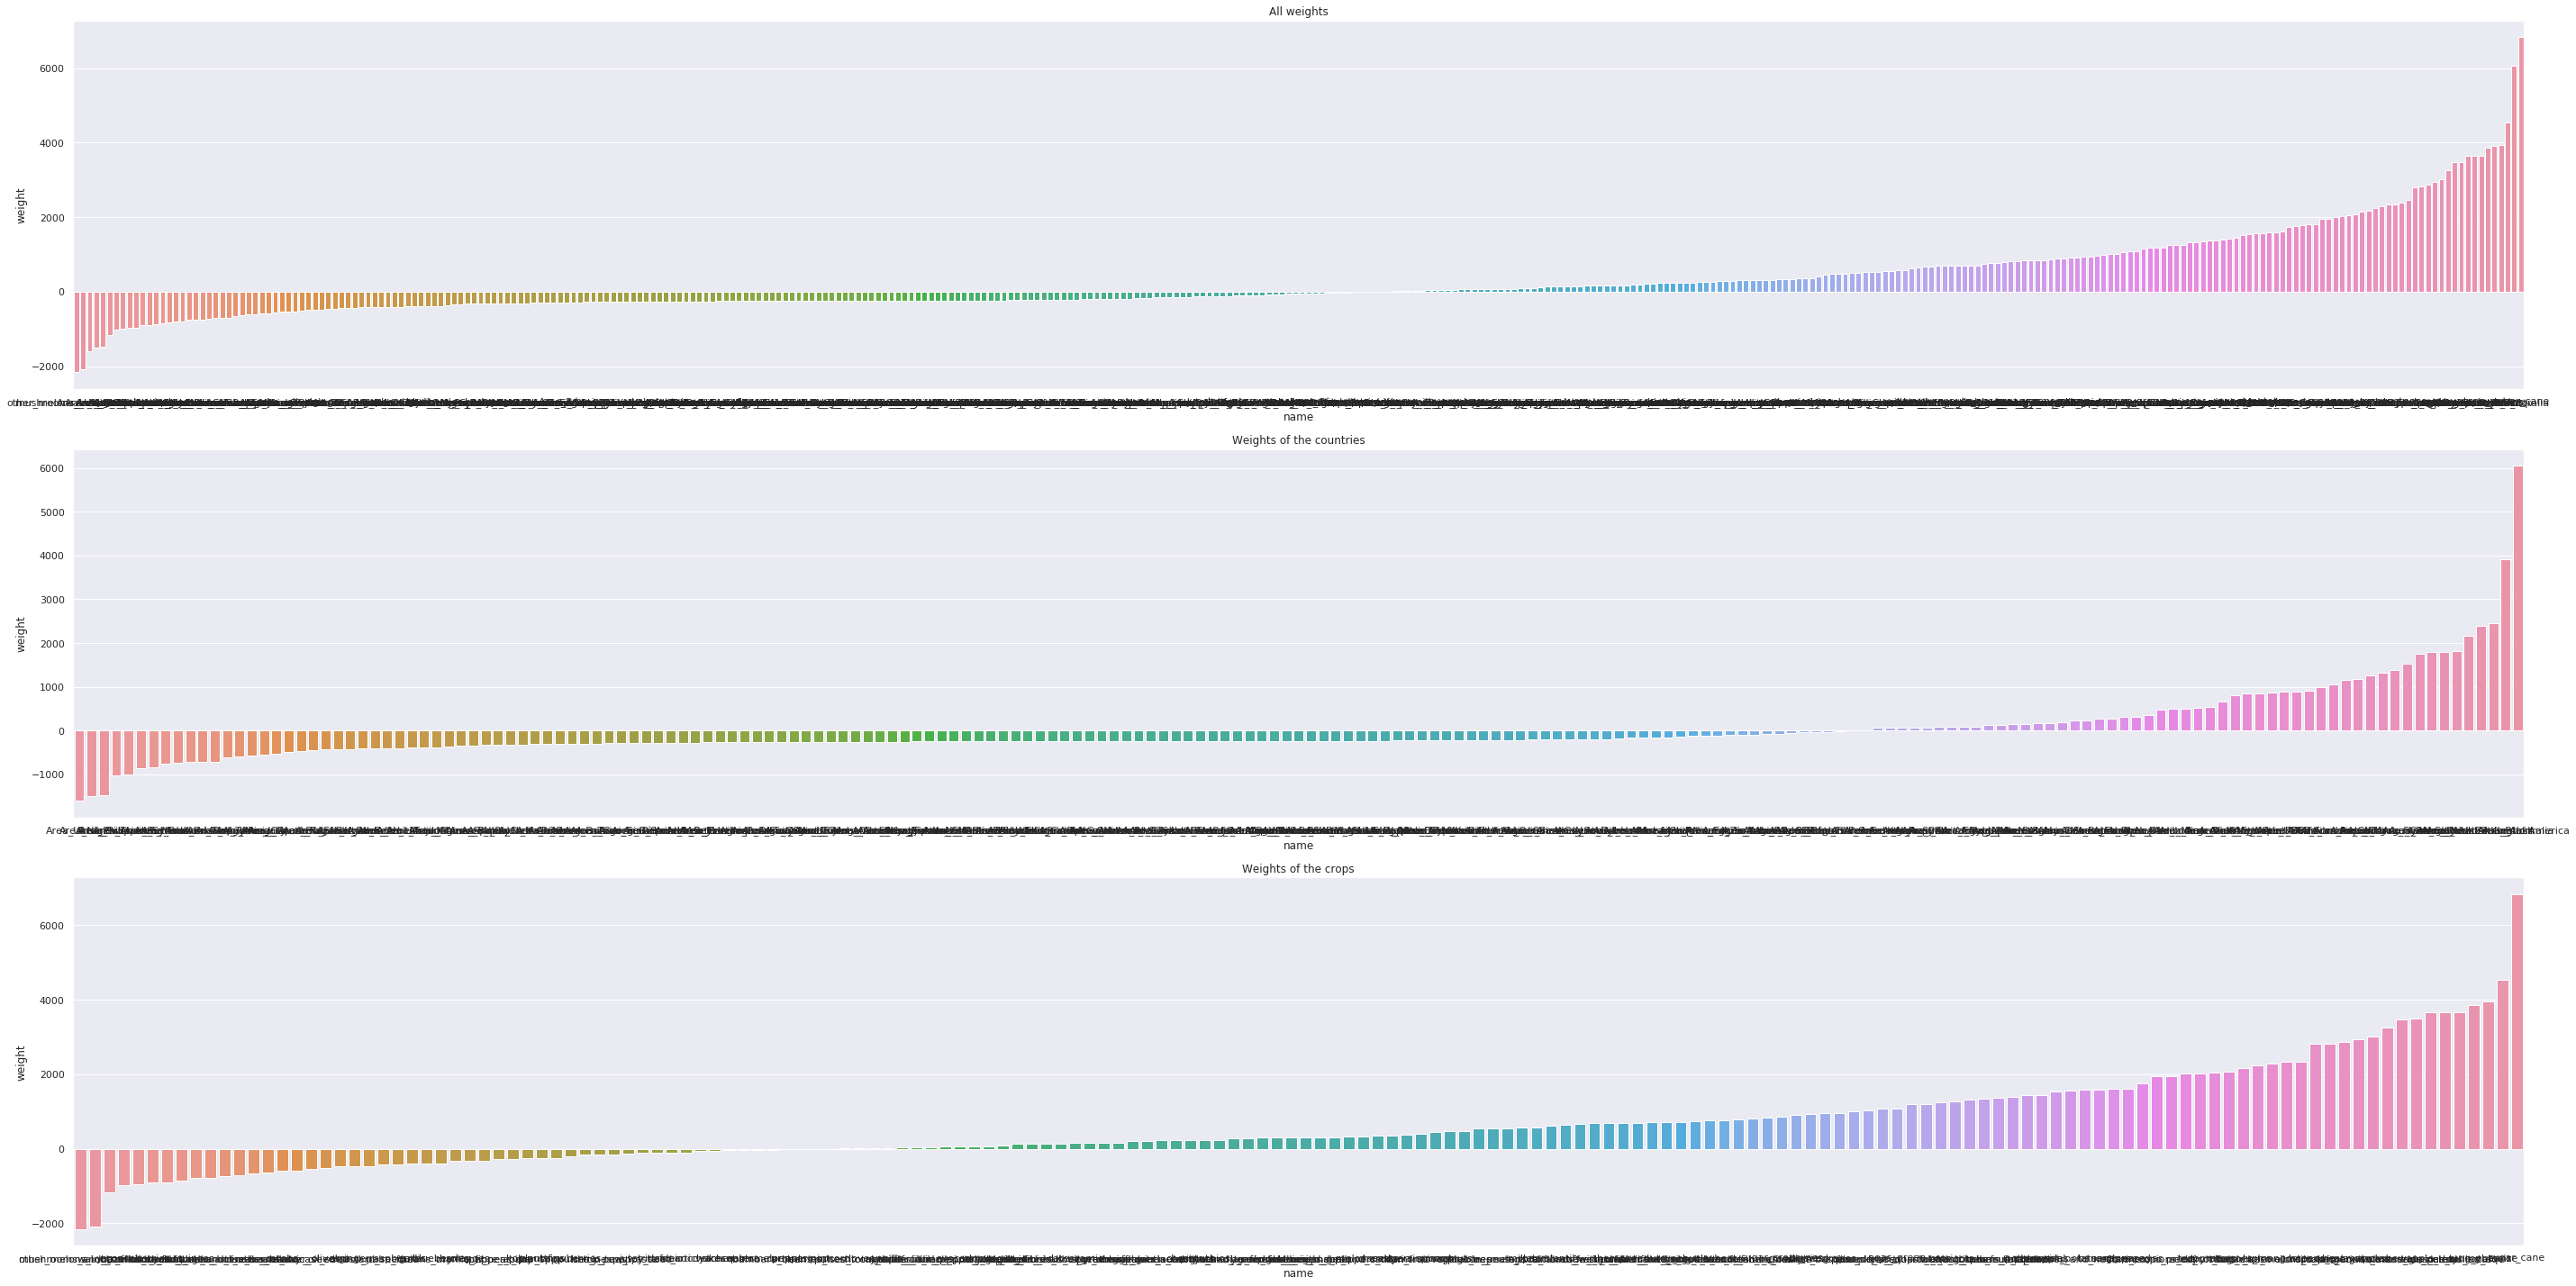

In [11]:
fg = plt.figure(figsize=(40,20))

axes1 = fg.add_subplot(3,1,1)
sns.barplot(x="name", y="weight", data=weights, ax=axes1)
axes1.set_title("All weights")

axes2 = fg.add_subplot(3,1,2)
sns.barplot(x="name", y="weight", data=weights.where(weights.name.str.contains("Area")).dropna(), ax=axes2)
axes2.set_title("Weights of the countries")

axes3 = fg.add_subplot(3,1,3)
sns.barplot(x="name", y="weight", data=weights.mask(weights.name.str.contains("Area")).mask(weights.name == "Year").dropna(), ax=axes3)
axes3.set_title("Weights of the crops")

fg.tight_layout()

In [12]:
weights.where(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight")#.where("weight > 0")

,name,weight
339,Area_Sweden,13.2048
325,Area_Senegal,63.8552
266,Area_Kenya,67.8984
303,Area_Norway,69.4197
180,Area_Austria,71.6935
309,Area_Peru,75.0356
334,Area_South Africa,76.5428
340,Area_Switzerland,76.5858
226,Area_Egypt,88.2928
187,Area_Belgium,89.551


In [13]:
weights.mask(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight").head()

,name,weight
125,pulses_total,5.18685
0,Year,9.79324
41,cloves,11.7426
35,chicory_roots,14.0448
162,vanilla,22.7541


## New model for predictions

In order to obtain better predictions, we decided to restart the process. Using linear regressions, we compute the emissions produced by each crops.

In [14]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .mask(dataCrops.country_or_area.isin(["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]))\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
crops.head(5)

,Area,Year,Unit area,Value area,category
282,Caribbean +,2007.0,Ha,10000.0,agave_fibres_nes
283,Caribbean +,2006.0,Ha,10000.0,agave_fibres_nes
284,Caribbean +,2005.0,Ha,10000.0,agave_fibres_nes
285,Caribbean +,2004.0,Ha,10000.0,agave_fibres_nes
286,Caribbean +,2003.0,Ha,10000.0,agave_fibres_nes


In [15]:
listCountries = ["United States of America", "India", "Switzerland", "United Kingdom", "China"]
filterCrops = ["cereals_total", "cereals_rice_milled_eqv","pulses_total", "coarse_grain_total", "treenuts_total"]

#cropsEmissionsNormalized = crops.where(crops.Area.isin(listCountries)).dropna()
cropsEmissionsNormalized = crops
totalHarvestedArea = cropsEmissionsNormalized.groupby(["Area","Year"]).sum()#.drop(["Year"], axis=1)#.rename("Value area", "Total area harvested")
totalHarvestedArea.columns = ["Total area harvested"]
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, totalHarvestedArea, how="left", on=['Area',"Year"])
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsEmissionsNormalized = cropsEmissionsNormalized.dropna().dropna(subset=["Unit emissions"])
cropsEmissionsNormalized["Value emissions"] = cropsEmissionsNormalized["Value area"]*cropsEmissionsNormalized["Value emissions"]/(cropsEmissionsNormalized["Total area harvested"]*cropsEmissionsNormalized["Total area harvested"])
cropsEmissionsNormalized = cropsEmissionsNormalized.mask(cropsEmissionsNormalized.category.isin(filterCrops)).dropna()
cropsEmissionsNormalized.head(5)

,Area,Year,Unit area,Value area,category,Total area harvested,Area Code,Unit emissions,Value emissions
94,Colombia,2007.0,Ha,17500.0,agave_fibres_nes,8073504.0,44.0,Gigagrams,0.000016
95,Colombia,2006.0,Ha,17500.0,agave_fibres_nes,7727624.0,44.0,Gigagrams,0.000016
96,Colombia,2005.0,Ha,17500.0,agave_fibres_nes,9095840.0,44.0,Gigagrams,0.000012
97,Colombia,2004.0,Ha,17294.0,agave_fibres_nes,9330644.0,44.0,Gigagrams,0.000011
98,Colombia,2003.0,Ha,17094.0,agave_fibres_nes,8884880.0,44.0,Gigagrams,0.000012


**cropsEmissionsNormalized** is a dataframe containing the value of emissions per crops, per country and per year. The total emissions for a given country and a given year was split over the different crops using their ratio of harvested area over the total harvested area. Then, these emissions were again normalized by the total harvested area, in order to obtain comparable results above all the countries. 

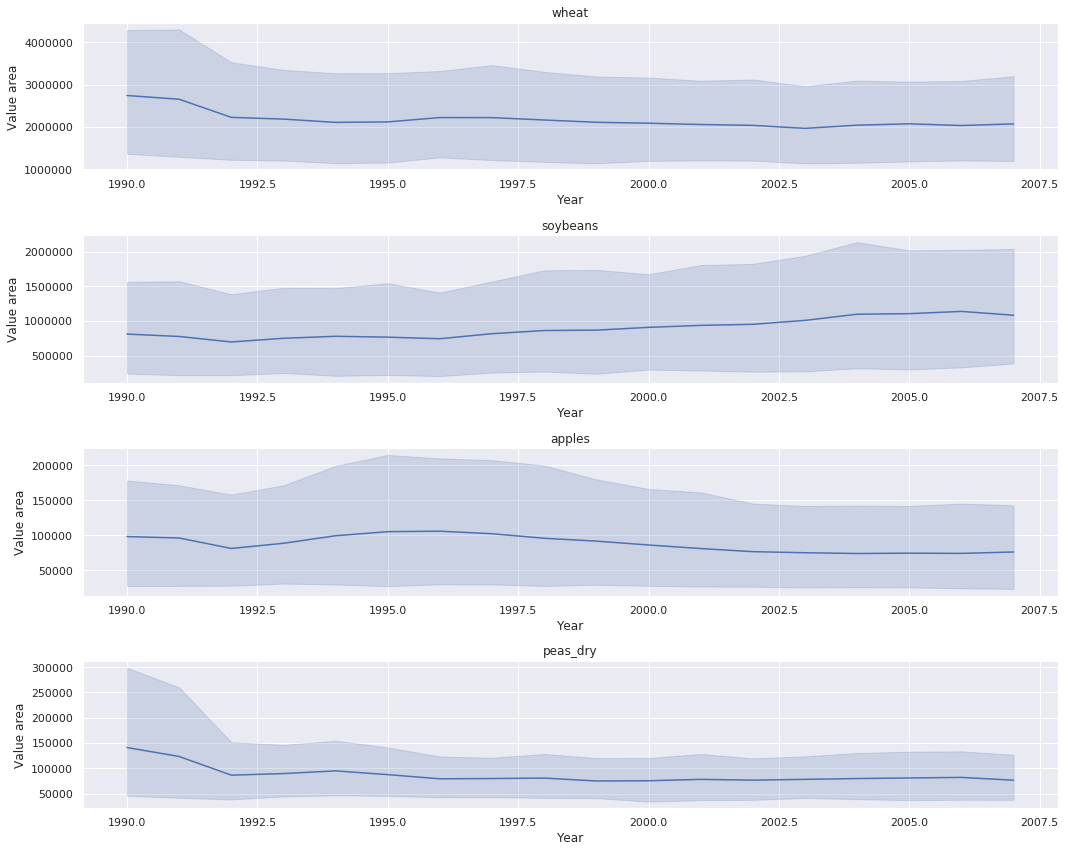

In [16]:
fg = plt.figure(figsize=(15,12))

i = 1

listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    sns.lineplot(x="Year", y="Value area",\
                data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.category == c).dropna(),\
                ax=axes)
    axes.set_title(c)
    i = i+1

fg.tight_layout()

On the graph above, you can see the evolution in time of the *area harvested* for different crops. Except for *wheat*, there is a slight increase for each of the above. It is strange if we compare this to the evolution of the population, which more or less doubled during the last 3 decades. This could be explained by the industrialization of the agriculture, which requires less area to produce a similar amount of food.

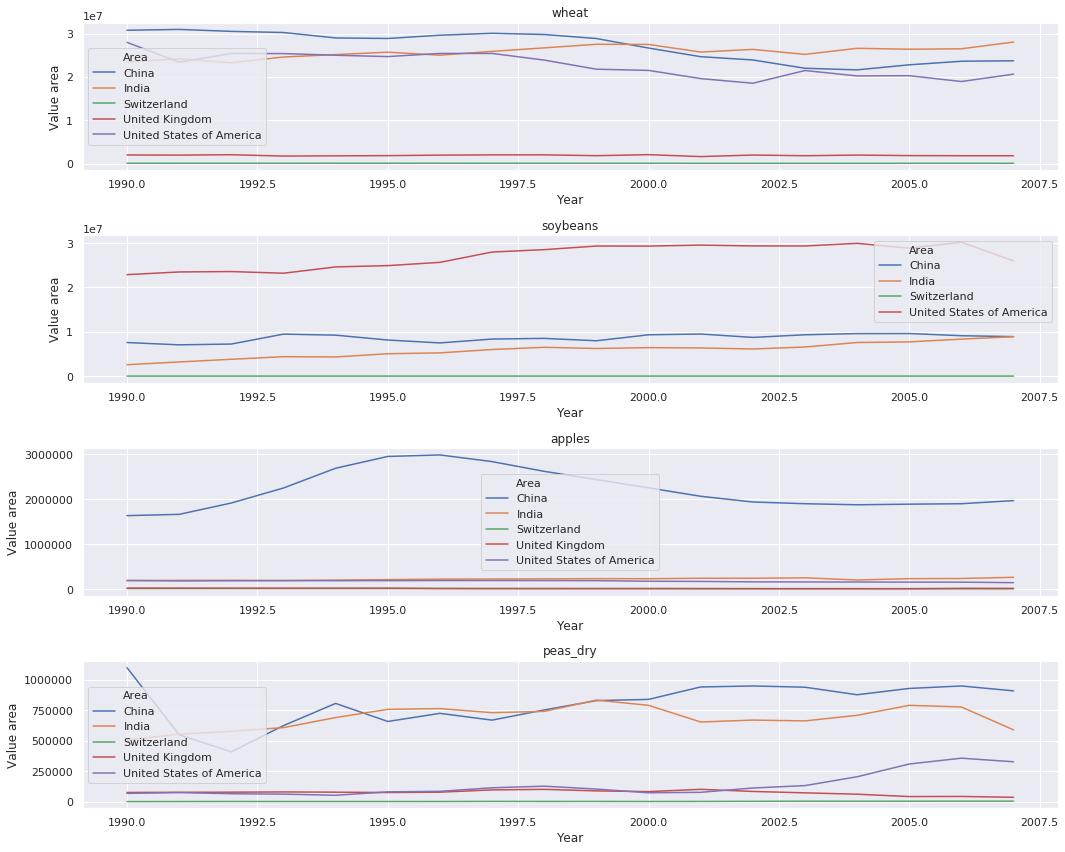

In [17]:
fg = plt.figure(figsize=(15,12))

i = 1

listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    sns.lineplot(x="Year", y="Value area", hue="Area",\
                data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.category == c)\
                 .where(cropsEmissionsNormalized.Area.isin(listCountries)).dropna(),\
                ax=axes)
    axes.set_title(c)
    i = i+1

fg.tight_layout()

This graph gives a preview of the evolution of these crops for each country. They all follow the overall evolution and none of them demonstrate a clear increase or decrease in the harvesting of these crops.

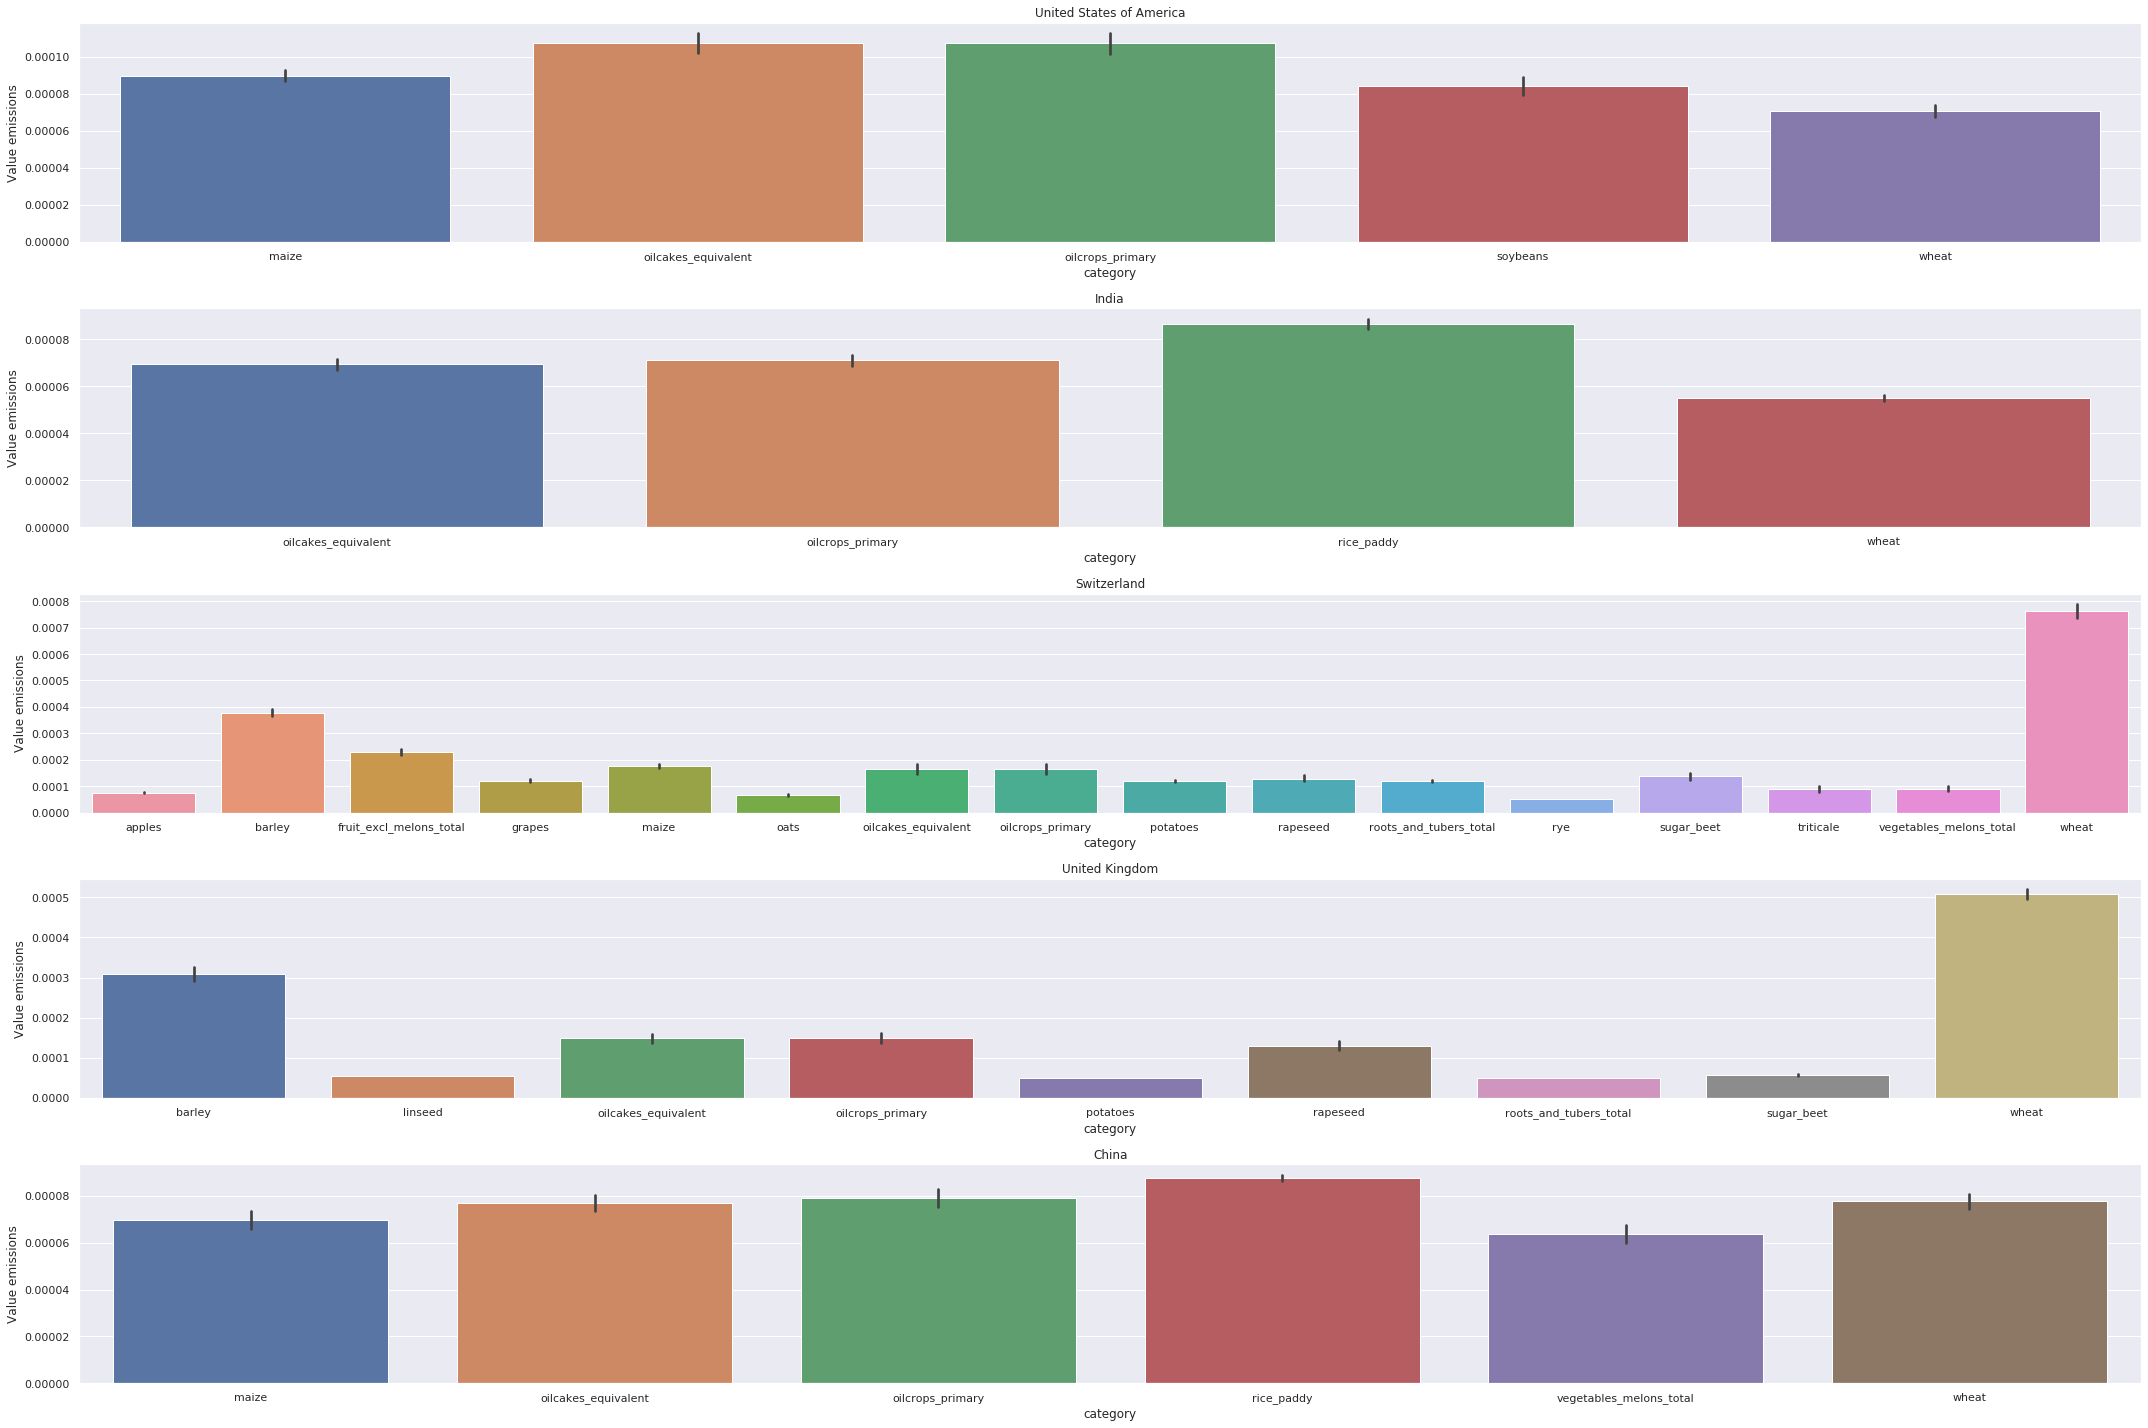

In [18]:
fg = plt.figure(figsize=(30,20))

i = 1

for c in listCountries:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(5,1,i)
    try:
        sns.barplot(x="category", y="Value emissions",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).where(cropsEmissionsNormalized["Value emissions"] > 0.00005).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    i = i+1

fg.tight_layout()

In the plot above, we show the **normalized emissions values** for the considered countries and we only display the crops that are the most "emitting". One very interesting fact is that Switzerland as well as UK seems to have a really considerable number of crops they grow that emits over the threshold we set. In order to investigate this, we made the graph below.

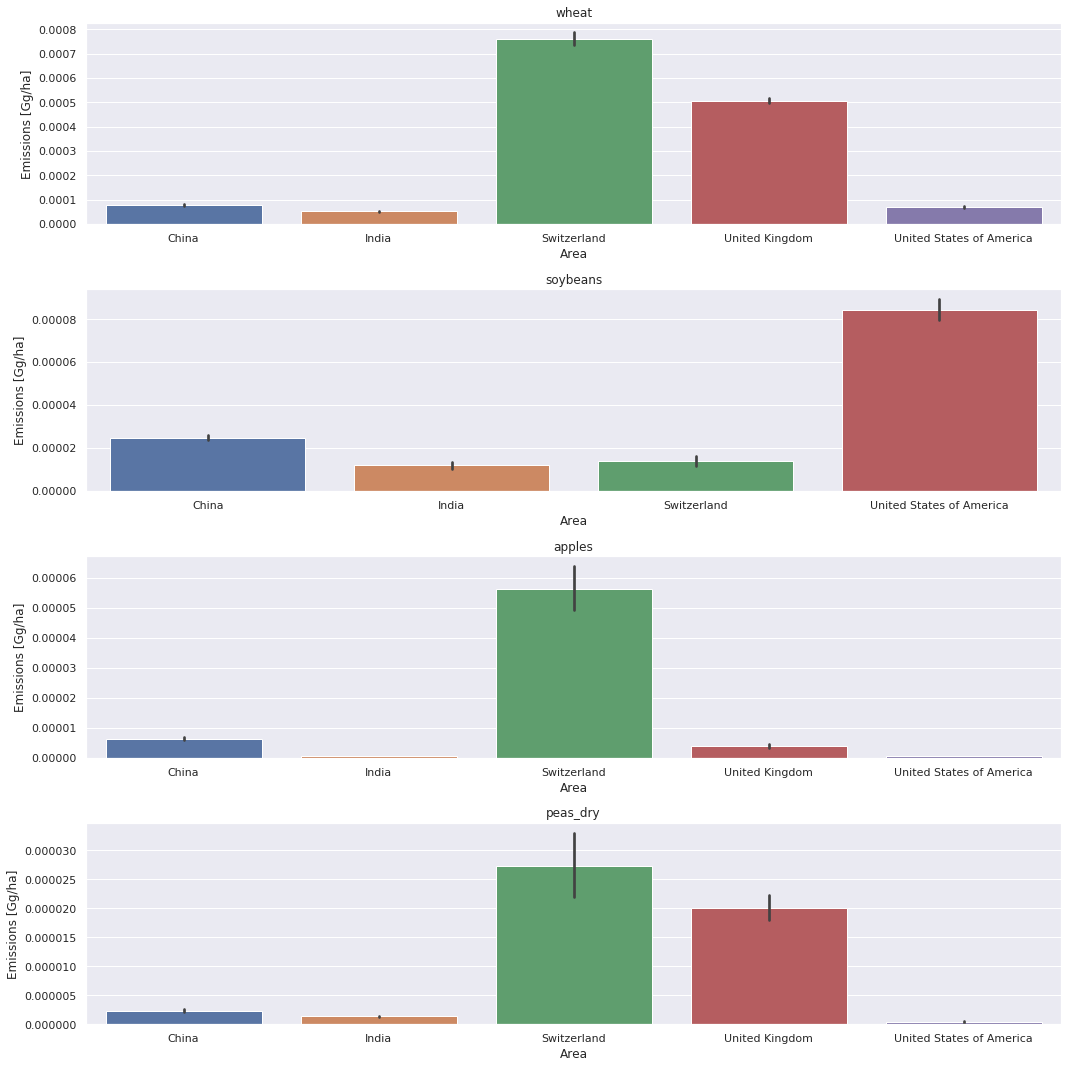

In [19]:
fg = plt.figure(figsize=(15,15))

i = 1

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    try:
        sns.barplot(x="Area", y="Value emissions",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).where(cropsEmissionsNormalized["category"] == c).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    axes.set_ylabel("Emissions [Gg/ha]")
    i = i+1

fg.tight_layout()

fg.savefig("emissions_by_unit_area_crop.eps")

This graph shows for 4 different crops, their normalized emissions value, aggregated in time. This is very insightful as it appears systematically that producing one of this type of crop in Switzerland, in UK or in US for the soybeans, emits more greenhouse gas than producing this in China or in India. This could be the consequence of the size of the production. Lets now compare the area harvested for each of these crops in these countries.

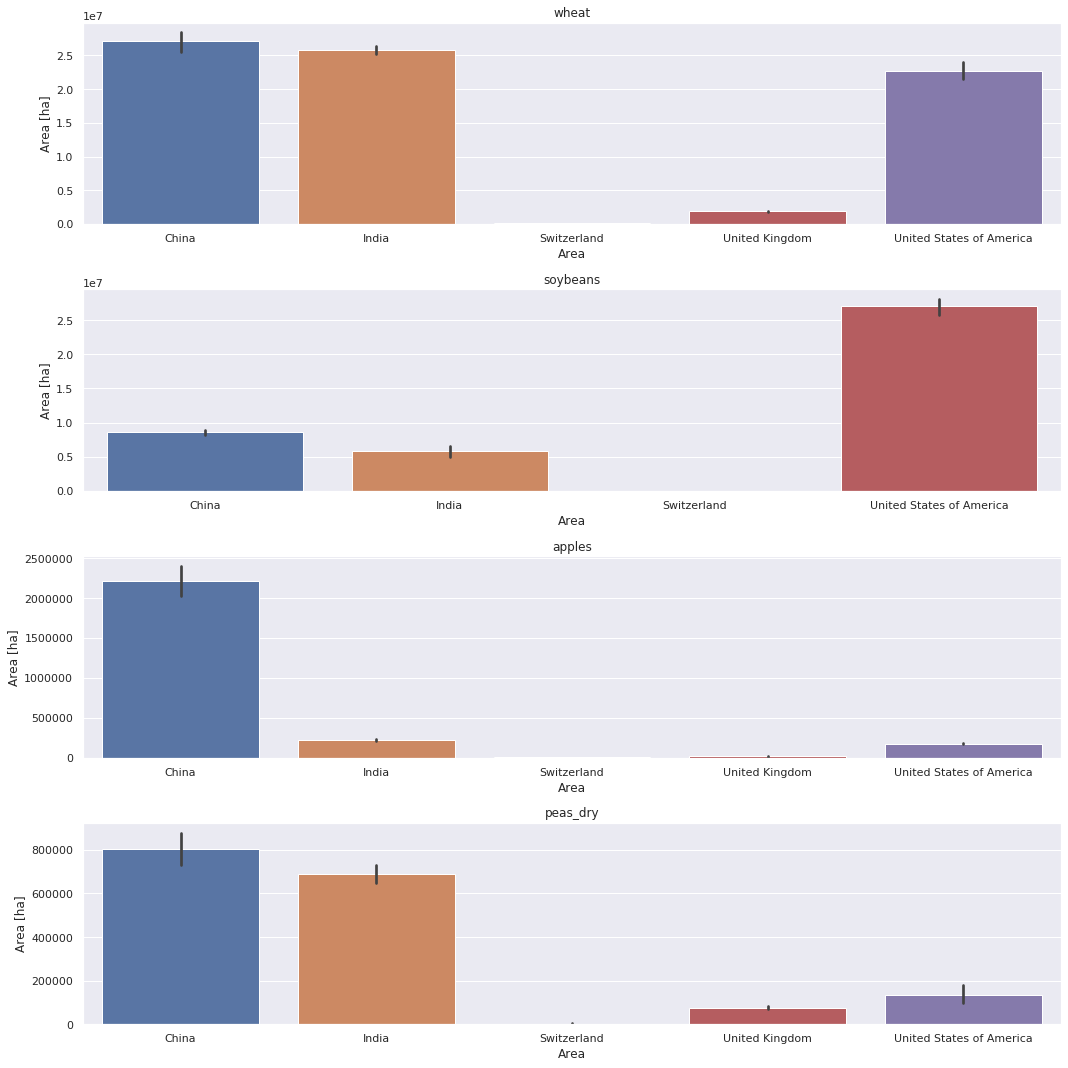

In [20]:
fg = plt.figure(figsize=(15,15))

i = 1
listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(len(listCrops),1,i)
    try:
        sns.barplot(x="Area", y="Value area",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).where(cropsEmissionsNormalized["category"] == c).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    axes.set_ylabel("Area [ha]")
    i = i+1

fg.tight_layout()
fg.savefig("area_crop.eps")

Here you clearly see that the production in China and in India are considerably bigger than those in United Kingdom or Switzerland. Therefore, we could argue that producing more is more efficient. However, the case of soybeans counterbalance this argument as the US is at the same time the biggest producer and least efficient producer of soybeans in terms of gas emissions. This could be put in relation with many other factors such as:

- human vs machine use in fields,
- automatisation,
- technical knowledge in agriculture,
- fertilizer and pesticide use.

## Create a model to assess the environmental efficiency for each crop

We will know create a model to predict the efficiency of each crop. This model will then be used to compute the emissions related to each crop in the near future. Based on this, we will also create a model to predict the agriculture type in each country in terms of crop development and area use in the next years. By combinig these two models, we will then try to predict the overall emissions for each country.

In [21]:
def create_model_for_crop(crop):
    cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.category ==crop).dropna()
    lm = LinearRegression()
    
    cropData = cropData.groupby("Year").sum().reset_index()

    X = cropData[["Year"]]
    Y = cropData[["Value emissions"]]

    lm.fit(X,Y)
    
    return lm

models = []

for crop in cropsEmissionsNormalized.category.unique():
    models.append((crop,create_model_for_crop(crop)))
    
cropsModelsEmissionsPerUnitArea = pd.DataFrame(models, columns=("crop","model_emissions"))

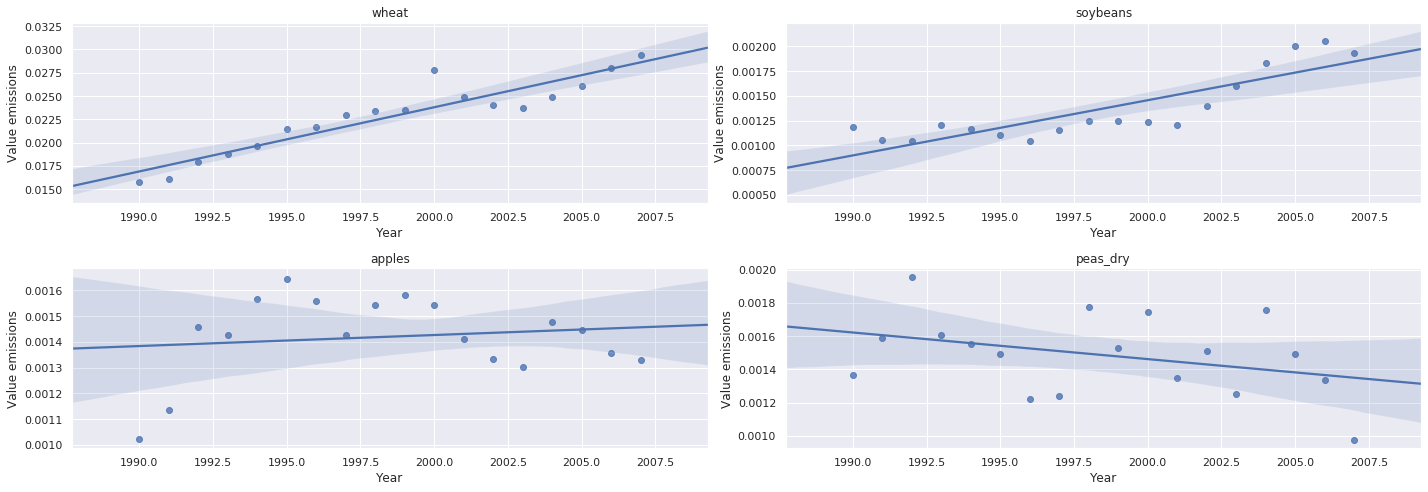

In [22]:
fg = plt.figure(figsize=(20,7))

i = 1
listCrops = ["wheat","soybeans", "apples", "peas_dry"]

for c in listCrops:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(2,2,i)
    cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized["category"] == c)\
                                        .dropna()\
                                        .groupby("Year").sum().reset_index()
    try:
        sns.regplot(x="Year", y="Value emissions",\
                    data=cropData,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    i = i+1

fg.tight_layout()

As it can be seen, some crops have a strong linear dependency while other crops can have very sparse data and a probably difficult to predict behaviour. In some cases it is very relevant to make linear regressions. For the sake of simplicity, we will keep the linear regressions for all the crops.

In [23]:
def get_model_crop(crop, cropsData):
    cropsData = cropsData.where(cropsData.category ==crop).dropna()
    
    lm = LinearRegression()
    
    cropsData = cropsData.groupby("Year").sum().reset_index()
    
    X = cropsData[["Year"]]
    Y = cropsData[["Value area"]]
    
    try:
        lm.fit(X,Y)
    except ValueError as e:
        #print(str(e))
        return np.nan
    
    return lm

def get_model_crops_country(country):
    cropsData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area ==country).dropna()
    
    models = []

    for crop in cropsEmissionsNormalized.category.unique():
        models.append((crop,get_model_crop(crop, cropsData)))
    
    cropsModelsGrowth = pd.DataFrame(models, columns=("crop","model_growth"))
    
    return cropsModelsGrowth

class PredictorEmissionsCountry():
    def __init__(self, country, modelCrops, modelEmissionsByCrops):
        self.country = country
        self.modelCrops = modelCrops
        self.modelEmissionsByCrops = modelEmissionsByCrops
        
    def predict_emissions(self, startYear, endYear):
        years = []
        for i in range(startYear, endYear):
            years.append(i)
            
        def compute_production_area(row):
            return (row.model_growth.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions(row):
            return (row.production_area*row.emissions_per_unit_area,)
        def flatten(arr):
            flatArr = []
            for i in arr:
                flatArr.append(i[0])
            return flatArr

        m = pd.merge(self.modelCrops, self.modelEmissionsByCrops, how="left", on=['crop']).dropna()
        m = m.join(m.apply(compute_production_area, axis=1, result_type="expand")).rename(columns={0:"production_area"})
        
        m = m.join(m.apply(compute_emissions_per_unit_area, axis=1, result_type="expand")).rename(columns={0:"emissions_per_unit_area"})
        m = m.join(m.apply(compute_emissions, axis=1, result_type="expand")).rename(columns={0:"emissions"})
        m.emissions = m.emissions.apply(flatten)
        m = pd.DataFrame(m.emissions.tolist(), columns=years)

        m = m.sum(0)
        return pd.DataFrame(m,columns=["emissions"]).reset_index().rename(columns={"index":"year"})

def get_model_emissions_countries(listCountries):
    #get_model_crops_country(country)
    
    predictorsEmissions = []

    for country in cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).dropna().Area.unique():
        predictorsEmissions.append(PredictorEmissionsCountry(country,\
                                                            get_model_crops_country(country),\
                                                            cropsModelsEmissionsPerUnitArea))
        print("Predictor for " + country + " done.")
    
    return predictorsEmissions

Predictor for China done.
Predictor for United States of America done.
Predictor for India done.
Predictor for Switzerland done.
Predictor for United Kingdom done.


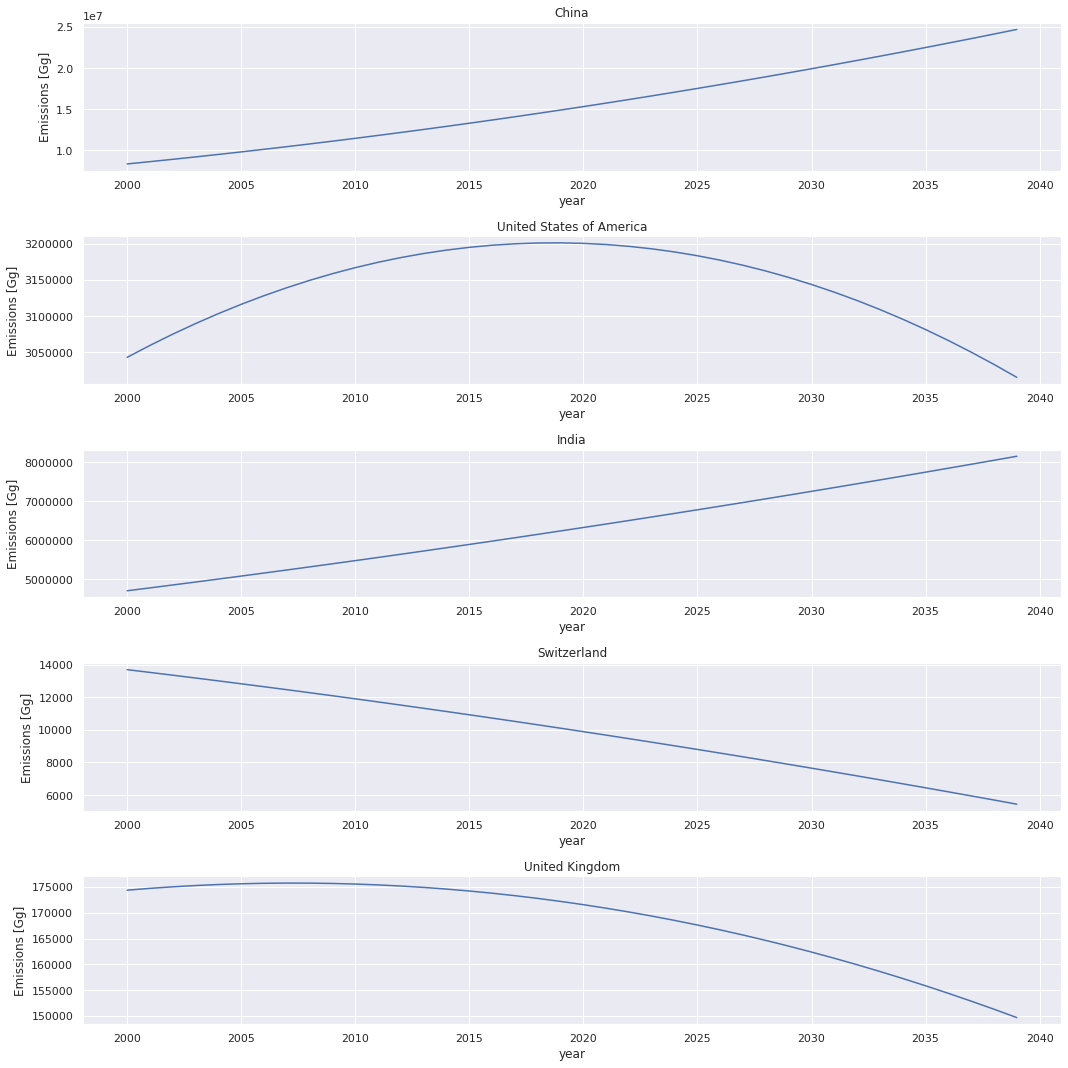

In [24]:
models = get_model_emissions_countries(listCountries)

fg = plt.figure(figsize=(15,15))

i = 1

for mc in models:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    emissions = mc.predict_emissions(2000,2040)
    axes = fg.add_subplot(5,1,i)
    try:
        sns.lineplot(x="year", y="emissions",data=emissions,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(mc.country)
    axes.set_ylabel("Emissions [Gg]")
    i = i+1

fg.tight_layout()
fg.savefig("emissions_prediction.eps")

Using the model above, these are the predictions for the emissions of the selected countries. It is very impressive to see how China and India, which could still be considered as developping countries if we consider the life quality of the poorest part of the population, have continuously increasing emissions. However, more developped countries such as US, UK and Switzerland seems to be able to mitigate and reverse the growth of their emissions. This has still to be compared with the growth of the agriculture in general in these countries, which could be the main explanation of this evolution.

Predictor for China done.
Predictor for United States of America done.
Predictor for India done.
Predictor for Switzerland done.
Predictor for United Kingdom done.


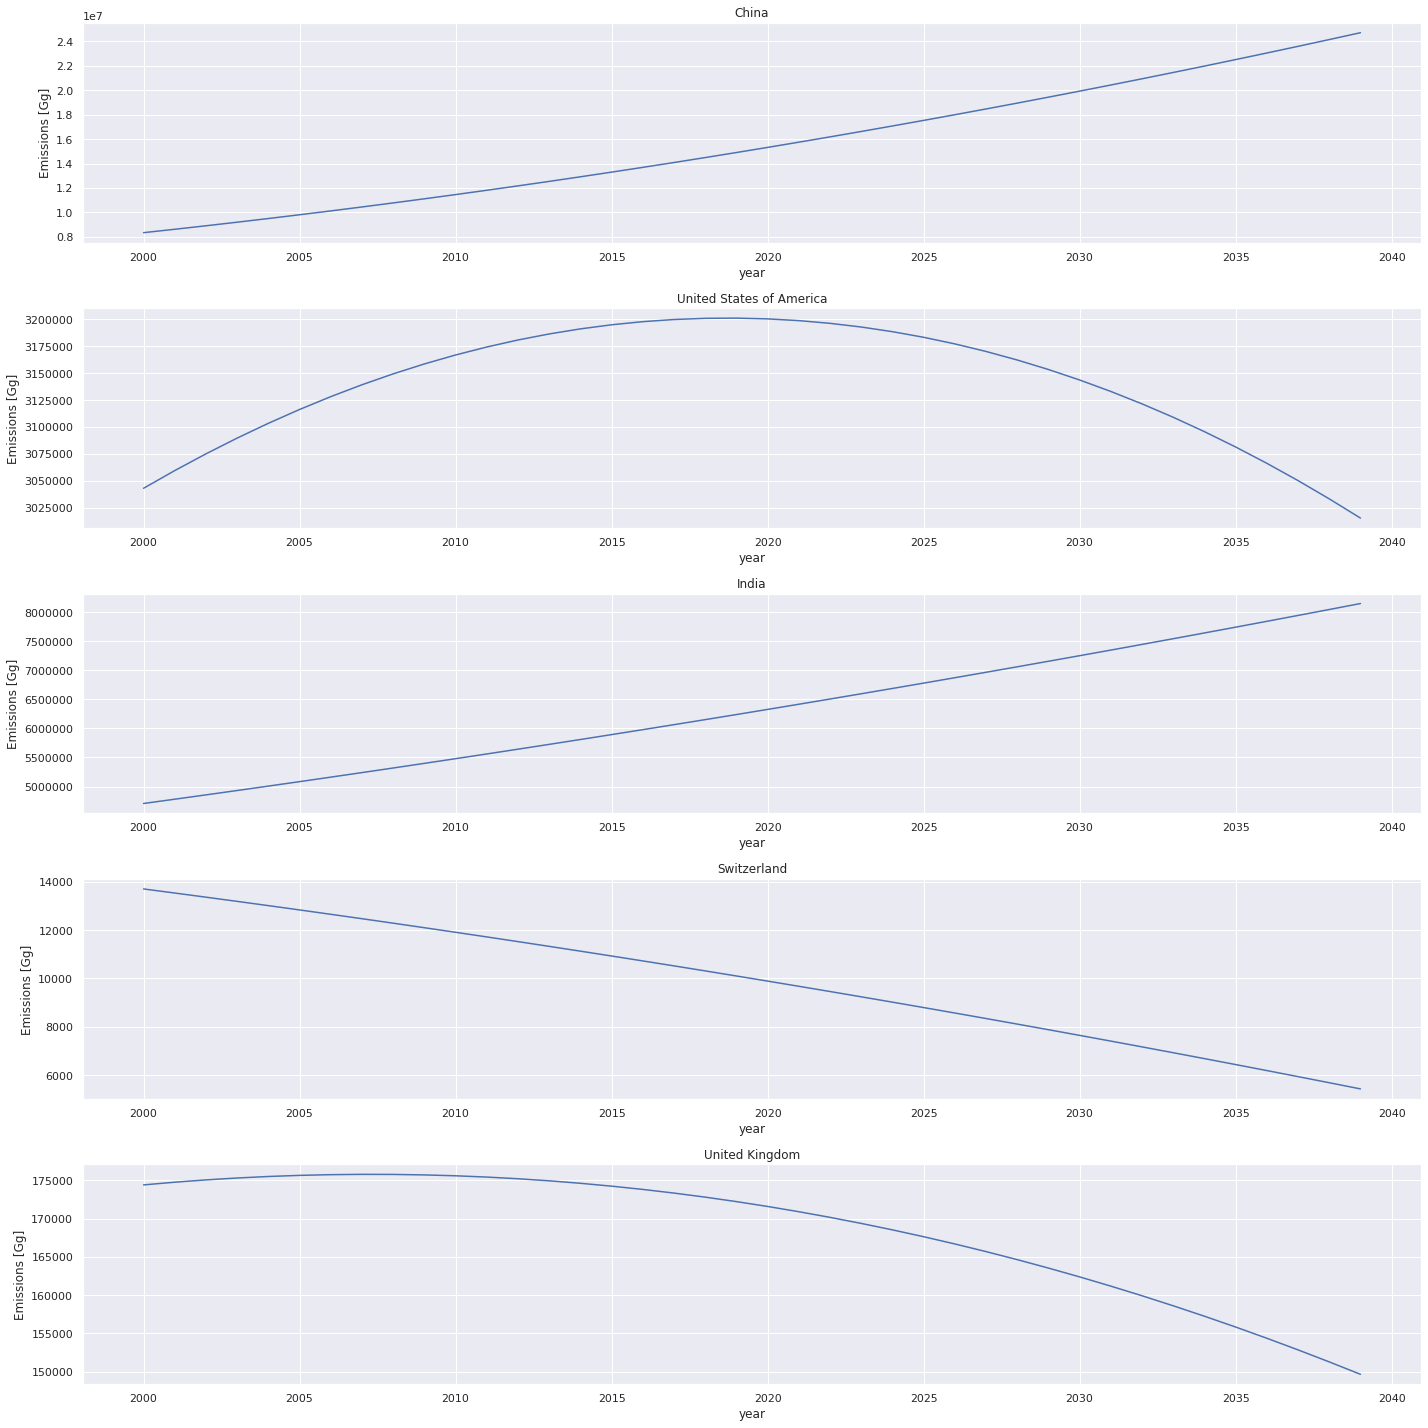

In [25]:
models = get_model_emissions_countries(listCountries)

fg = plt.figure(figsize=(20,20))

i = 1

for mc in models:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    emissions = mc.predict_emissions(2000,2040)
    axes = fg.add_subplot(5,1,i)
    try:
        sns.lineplot(x="year", y="emissions",data=emissions,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(mc.country)
    axes.set_ylabel("Emissions [Gg]")
    i = i+1

fg.tight_layout()
fg.savefig("emissions_prediction.eps")